### Preprocessing

#### Steps:  

1.	Loads raw rating files  
2.	Keeps only first 60 seconds  
3.	Removes first 5 seconds  
4.	Interpolates both time series onto a shared regular grid (10 Hz)  
5.	Saves a plot of Lead + Follow  
6.	Saves a clean preprocessed CSV per dyad per condition  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# PARAMETERS
# ============================================================
root_folder = "MoCap_Togetherness_Ratings"
save_root = os.path.join(root_folder, "Preprocessed_Signals_Clean")
os.makedirs(save_root, exist_ok=True)

TRIM_TO_SECONDS = 60       # keep first 60 seconds
CUT_FIRST_SECONDS = 5      # then remove first 5 seconds
REGULAR_FS = 10            # interpolate to 10 Hz grid 
show_plots = False


# ============================================================
# HELPER
# ============================================================
def save_plot(fig, path):
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.close(fig)


# ============================================================
# MAIN LOOP OVER PAIRS
# ============================================================
for pair_folder in sorted(os.listdir(root_folder)):
    pair_path = os.path.join(root_folder, pair_folder)
    if not os.path.isdir(pair_path):
        continue

    files = [f for f in os.listdir(pair_path) if f.startswith("ratingcont") and f.endswith(".csv")]
    if not files:
        continue

    pair_id = pair_folder

    # detect roles
    roles = sorted({f.split("_")[-1].replace(".csv", "") for f in files})
    leads = [r for r in roles if r.startswith("L")]
    follows = [r for r in roles if r.startswith("F")]

    if not leads or not follows:
        print(f"Skipping {pair_id}: Lead/Follow missing.")
        continue

    lead_id = leads[0]
    follow_id = follows[0]

    conditions = sorted(set(f.split("_")[2] for f in files))

    for condition in conditions:
        print(f"\n=== Processing {pair_id} ({condition}) ===")

        # ------------------------------
        # 1) LOAD FILES
        # ------------------------------
        lead_file = [f for f in files if f"_{condition}_" in f and f.endswith(f"_{lead_id}.csv")]
        follow_file = [f for f in files if f"_{condition}_" in f and f.endswith(f"_{follow_id}.csv")]

        if not (lead_file and follow_file):
            print(f"No matching files for {pair_id} - {condition}")
            continue

        df_lead = pd.read_csv(os.path.join(pair_path, lead_file[0]),
                              header=None, names=["Time", "Lead_Rating"])
        df_follow = pd.read_csv(os.path.join(pair_path, follow_file[0]),
                                header=None, names=["Time", "Follow_Rating"])


        # ------------------------------
        # 2) TRIM TO FIRST 60 SECONDS
        # ------------------------------
        df_lead = df_lead[df_lead["Time"] <= TRIM_TO_SECONDS].reset_index(drop=True)
        df_follow = df_follow[df_follow["Time"] <= TRIM_TO_SECONDS].reset_index(drop=True)


        # ------------------------------
        # 3) CUT OFF FIRST 5 SECONDS
        # ------------------------------
        df_lead = df_lead[df_lead["Time"] >= CUT_FIRST_SECONDS].reset_index(drop=True)
        df_follow = df_follow[df_follow["Time"] >= CUT_FIRST_SECONDS].reset_index(drop=True)

        # reset time to start at zero
        df_lead["Time"] -= CUT_FIRST_SECONDS
        df_follow["Time"] -= CUT_FIRST_SECONDS


        # ------------------------------
        # 4) INTERPOLATE ONTO A REGULAR TIME GRID
        # ------------------------------
        t_end = min(df_lead["Time"].max(), df_follow["Time"].max())
        grid = np.arange(0, t_end, 1 / REGULAR_FS)

        lead_interp = np.interp(grid, df_lead["Time"], df_lead["Lead_Rating"])
        follow_interp = np.interp(grid, df_follow["Time"], df_follow["Follow_Rating"])

        merged_df = pd.DataFrame({
            "Time": grid,
            "Lead_Rating": lead_interp,
            "Follow_Rating": follow_interp
        })


        # ------------------------------
        # 5) VISUALIZE & SAVE PLOT
        # ------------------------------
        pair_save_folder = os.path.join(save_root, pair_id)
        plots_folder = os.path.join(pair_save_folder, "plots")
        os.makedirs(plots_folder, exist_ok=True)

        fig, ax = plt.subplots()
        ax.plot(merged_df["Time"], merged_df["Lead_Rating"], label="Lead")
        ax.plot(merged_df["Time"], merged_df["Follow_Rating"], label="Follow")
        ax.set(title=f"Preprocessed Togetherness — {pair_id} ({condition})",
               xlabel="Time (s)", ylabel="Rating")
        ax.legend(); ax.grid(True)
        save_plot(fig, os.path.join(plots_folder, f"{pair_id}_{condition}_preprocessed.png"))

        if show_plots:
            plt.show()


        # ------------------------------
        # 6) SAVE CLEAN PREPROCESSED SIGNAL
        # ------------------------------
        out_path = os.path.join(pair_save_folder,
                                f"{pair_id}_{condition}_preprocessed_clean.csv")
        merged_df.to_csv(out_path, index=False)
        print(f"Saved cleaned signal → {out_path}")

print("\nAll preprocessing complete!")



=== Processing L10F10 (closed) ===
Saved cleaned signal → MoCap_Togetherness_Ratings\Preprocessed_Signals_Clean\L10F10\L10F10_closed_preprocessed_clean.csv

=== Processing L10F10 (open) ===
Saved cleaned signal → MoCap_Togetherness_Ratings\Preprocessed_Signals_Clean\L10F10\L10F10_open_preprocessed_clean.csv

=== Processing L10F9 (closed) ===
Saved cleaned signal → MoCap_Togetherness_Ratings\Preprocessed_Signals_Clean\L10F9\L10F9_closed_preprocessed_clean.csv

=== Processing L10F9 (open) ===
Saved cleaned signal → MoCap_Togetherness_Ratings\Preprocessed_Signals_Clean\L10F9\L10F9_open_preprocessed_clean.csv

=== Processing L11F11 (closed) ===
Saved cleaned signal → MoCap_Togetherness_Ratings\Preprocessed_Signals_Clean\L11F11\L11F11_closed_preprocessed_clean.csv

=== Processing L11F11 (open) ===
Saved cleaned signal → MoCap_Togetherness_Ratings\Preprocessed_Signals_Clean\L11F11\L11F11_open_preprocessed_clean.csv

=== Processing L11F12 (closed) ===
Saved cleaned signal → MoCap_Togethernes

### Dyadic togetherness, mean togetherness, corr

1. loads trimmed & preprocessed files (the ones ending in _preprocessed_clean.csv)  
2. computes Lead mean and Follow mean  
3. z-scores Lead and Follow means separately  
4. computes Dyadic Togetherness = (Lead_mean + Follow_mean) / 2  
5. z-scores dyadic togetherness  
6. computes Pearson correlation between Lead and Follow time series  
7. extracts dyad_id and condition from the filename  
8. saves everything into a single summary dataframe  

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore, pearsonr

# ============================================================
# CONFIGURATION
# ============================================================
data_folder = "MoCap_Togetherness_Ratings/Preprocessed_Signals_Clean"
save_path = "MoCap_Togetherness_Ratings/Togetherness_Summary.csv"

summary_rows = []


def parse_filename(fname):
    parts = fname.replace(".csv", "").split("_")
    dyad = parts[0]          # L3F4
    condition = parts[1]     # open
    return dyad, condition


# ============================================================
# MAIN LOOP
# ============================================================
files = sorted([
    f for f in os.listdir(data_folder)
    if f.endswith("_preprocessed_clean.csv")
])

for fname in files:
    file_path = os.path.join(data_folder, fname)
    dyad, condition = parse_filename(fname)

    df = pd.read_csv(file_path)

    lead = df["Lead_Rating"].to_numpy()
    follow = df["Follow_Rating"].to_numpy()

  
    # 1. Compute Means
    lead_mean = lead.mean()
    follow_mean = follow.mean()

 
    # 2. Dyadic togetherness
    dyad_together = (lead_mean + follow_mean) / 2

  
    # 3. Pearson correlation between time series
    corr, pval = pearsonr(lead, follow)

  
    # 4. Store summary
    summary_rows.append({
        "dyad": dyad,
        "condition": condition,
        "lead_mean": lead_mean,
        "follow_mean": follow_mean,
        "dyadic_togetherness": dyad_together,
        "lead_follow_corr": corr,
        "lead_follow_corr_p": pval
    })


# CREATE DATAFRAME
summary_df = pd.DataFrame(summary_rows)

# Z-SCORE ACROSS DYADS 
summary_df["lead_mean_z"] = zscore(summary_df["lead_mean"])
summary_df["follow_mean_z"] = zscore(summary_df["follow_mean"])
summary_df["dyadic_togetherness_z"] = zscore(summary_df["dyadic_togetherness"])


# SAVE
summary_df.to_csv(save_path, index=False)

print("\n===== TOGETHERNESS SUMMARY SAVED =====")
print(summary_df)
print(f"\nSaved to: {save_path}")



===== TOGETHERNESS SUMMARY SAVED =====
      dyad condition  lead_mean  follow_mean  dyadic_togetherness  \
0   L10F10    closed   0.122026     0.577619             0.349822   
1   L10F10      open   0.364391     0.566463             0.465427   
2    L10F9    closed   0.246693     0.326211             0.286452   
3    L10F9      open   0.285554     0.263511             0.274532   
4   L11F11    closed   0.433914     0.320564             0.377239   
5   L11F11      open   0.356615     0.204233             0.280424   
6   L11F12    closed   0.363151     0.175291             0.269221   
7   L11F12      open   0.368437     0.156701             0.262569   
8   L12F11    closed   0.218924     0.308601             0.263763   
9   L12F11      open   0.411781     0.202531             0.307156   
10  L12F12    closed   0.290477     0.182701             0.236589   
11  L12F12      open   0.309151     0.187928             0.248539   
12    L1F1    closed   0.759690     0.434069             0.5968

C:\Users\au605619\AppData\Local\Temp\ipykernel_23432\2383401551.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(lead, follow)


Loading Togetherness summary df

In [8]:
# Load the CSV files
Togetherness_Summary = pd.read_csv('MoCap_Togetherness_Ratings/Togetherness_Summary.csv')



In [9]:
print(Togetherness_Summary)

      dyad condition  lead_mean  follow_mean  dyadic_togetherness  \
0   L10F10    closed   0.122026     0.577619             0.349822   
1   L10F10      open   0.364391     0.566463             0.465427   
2    L10F9    closed   0.246693     0.326211             0.286452   
3    L10F9      open   0.285554     0.263511             0.274532   
4   L11F11    closed   0.433914     0.320564             0.377239   
5   L11F11      open   0.356615     0.204233             0.280424   
6   L11F12    closed   0.363151     0.175291             0.269221   
7   L11F12      open   0.368437     0.156701             0.262569   
8   L12F11    closed   0.218924     0.308601             0.263763   
9   L12F11      open   0.411781     0.202531             0.307156   
10  L12F12    closed   0.290477     0.182701             0.236589   
11  L12F12      open   0.309151     0.187928             0.248539   
12    L1F1    closed   0.759690     0.434069             0.596879   
13    L1F1      open   0.669762   

Turning Togetherness summary df into a long format

In [ ]:
import pandas as pd
import re

# Load summary data
df = pd.read_csv("MoCap_Togetherness_Ratings/Togetherness_Summary.csv")

# Rename dyad column
df = df.rename(columns={"dyad": "Pair_ID"})

# Extract participant IDs 
def extract_lead_follow(pair):
    match = re.match(r"(L\d+)(F\d+)", pair)
    if match:
        return match.group(1), match.group(2)
    return None, None

df["lead_id"], df["follow_id"] = zip(*df["Pair_ID"].apply(extract_lead_follow))


long_df = df.melt(
    id_vars=[
        "Pair_ID", "condition",
        "dyadic_togetherness",
        "lead_follow_corr", "lead_follow_corr_p",
        "lead_mean_z", "follow_mean_z",
        "lead_id", "follow_id"
    ],
    value_vars=["lead_mean", "follow_mean"],   # unpivot these
    var_name="role",
    value_name="rating_mean"
)

# Clean role name
long_df["role"] = long_df["role"].str.replace("_mean", "")


long_df["Participant_ID"] = long_df.apply(
    lambda row: row["lead_id"] if row["role"] == "lead" else row["follow_id"],
    axis=1
)

# Add role-specific z-scored mean
long_df["rating_mean_z"] = long_df.apply(
    lambda row: row["lead_mean_z"] if row["role"] == "lead" else row["follow_mean_z"],
    axis=1
)



# Save long format
long_df.to_csv("MoCap_Togetherness_Ratings/Togetherness_LongFormat.csv", index=False)

print(long_df.head(10))


  Pair_ID condition  dyadic_togetherness  lead_follow_corr  \
0  L10F10    closed             0.349822          0.538523   
1  L10F10      open             0.465427          0.681571   
2   L10F9    closed             0.286452          0.735625   
3   L10F9      open             0.274532          0.008090   
4  L11F11    closed             0.377239         -0.311606   
5  L11F11      open             0.280424          0.801161   
6  L11F12    closed             0.269221          0.785548   
7  L11F12      open             0.262569          0.486119   
8  L12F11    closed             0.263763          0.651268   
9  L12F11      open             0.307156          0.763773   

   lead_follow_corr_p  lead_mean_z  follow_mean_z lead_id follow_id  role  \
0        1.103529e-42    -1.641839       1.906786     L10       F10  lead   
1        2.340544e-76     0.023288       1.830907     L10       F10  lead   
2        9.207956e-95    -0.785335       0.196751     L10        F9  lead   
3        

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(long_df)

   Pair_ID condition  dyadic_togetherness  lead_follow_corr  \
0   L10F10    closed             0.349822          0.538523   
1   L10F10      open             0.465427          0.681571   
2    L10F9    closed             0.286452          0.735625   
3    L10F9      open             0.274532          0.008090   
4   L11F11    closed             0.377239         -0.311606   
5   L11F11      open             0.280424          0.801161   
6   L11F12    closed             0.269221          0.785548   
7   L11F12      open             0.262569          0.486119   
8   L12F11    closed             0.263763          0.651268   
9   L12F11      open             0.307156          0.763773   
10  L12F12    closed             0.236589          0.851467   
11  L12F12      open             0.248539          0.834635   
12    L1F1    closed             0.596879          0.750038   
13    L1F1      open             0.571664          0.857875   
14    L1F2    closed             0.587600          0.75

In [20]:
# rename columns
long_df = long_df.rename(columns={
    "condition": "Condition",
    "role": "Role"
})

In [ ]:
# save final long df
long_df.to_csv("MoCap_Togetherness_Ratings/Togetherness_LongFormat_final.csv", index=False)

#### Plots and summaries

In [3]:
import pandas as pd

In [5]:
# Load the CSV files
Togetherness_long = pd.read_csv('MoCap_Togetherness_Ratings/Togetherness_LongFormat_final.csv')

In [6]:
print(Togetherness_long)

   Pair_ID Condition  dyadic_togetherness  lead_follow_corr  \
0   L10F10    closed             0.349822          0.538523   
1   L10F10      open             0.465427          0.681571   
2    L10F9    closed             0.286452          0.735625   
3    L10F9      open             0.274532          0.008090   
4   L11F11    closed             0.377239         -0.311606   
..     ...       ...                  ...               ...   
79    L8F8      open             0.208899         -0.582911   
80   L9F10    closed             0.183434          0.902225   
81   L9F10      open             0.059295               NaN   
82    L9F9    closed             0.225906         -0.108562   
83    L9F9      open             0.309533          0.410427   

    lead_follow_corr_p  lead_mean_z  follow_mean_z lead_id follow_id    Role  \
0         1.103529e-42    -1.641839       1.906786     L10       F10    lead   
1         2.340544e-76     0.023288       1.830907     L10       F10    lead   
2  

In [ ]:
import numpy as np
import pandas as pd


condition_order = ["closed", "open"]
role_order = ["lead", "follow"] 

df = Togetherness_long.copy()
df["Condition"] = pd.Categorical(df["Condition"], categories=condition_order, ordered=True)
df["Role"] = pd.Categorical(df["Role"], categories=role_order, ordered=True)

def mean_sd_se(x: pd.Series):
    x = x.dropna()
    n = x.shape[0]
    m = x.mean() if n else np.nan
    sd = x.std(ddof=1) if n > 1 else np.nan
    se = sd / np.sqrt(n) if n > 1 else np.nan
    return pd.Series({"n": n, "mean": m, "sd": sd, "se": se})

# 1) Summary by Role (collapsed across conditions)
summary_by_role = (
    df.groupby("Role")["rating_mean"]
      .apply(mean_sd_se)
      .reset_index()
      .sort_values("Role")
)

# 2) Summary by Condition (collapsed across roles)
summary_by_condition = (
    df.groupby("Condition")["rating_mean"]
      .apply(mean_sd_se)
      .reset_index()
      .sort_values("Condition")
)

# 3) Summary by Role x Condition (separately)
summary_by_role_condition = (
    df.groupby(["Role", "Condition"])["rating_mean"]
      .apply(mean_sd_se)
      .reset_index()
      .sort_values(["Role", "Condition"])
)

print("\n=== Togetherness: BY ROLE ===")
print(summary_by_role.to_string(index=False))

print("\n=== Togetherness: BY CONDITION ===")
print(summary_by_condition.to_string(index=False))

print("\n=== Togetherness: BY ROLE x CONDITION ===")
print(summary_by_role_condition.to_string(index=False))





=== Togetherness: BY ROLE ===
  Role level_1  rating_mean
  lead       n    42.000000
  lead    mean     0.361001
  lead      sd     0.147318
  lead      se     0.022732
follow       n    42.000000
follow    mean     0.297284
follow      sd     0.148801
follow      se     0.022961

=== Togetherness: BY CONDITION ===
Condition level_1  rating_mean
   closed       n    42.000000
   closed    mean     0.347408
   closed      sd     0.162090
   closed      se     0.025011
     open       n    42.000000
     open    mean     0.310877
     open      sd     0.137722
     open      se     0.021251

=== Togetherness: BY ROLE x CONDITION ===
  Role Condition level_2  rating_mean
  lead    closed       n    21.000000
  lead    closed    mean     0.371909
  lead    closed      sd     0.165381
  lead    closed      se     0.036089
  lead      open       n    21.000000
  lead      open    mean     0.350094
  lead      open      sd     0.129959
  lead      open      se     0.028359
follow    closed 

C:\Users\au605619\AppData\Local\Temp\ipykernel_34164\3302108959.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Role")["rating_mean"]
C:\Users\au605619\AppData\Local\Temp\ipykernel_34164\3302108959.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Condition")["rating_mean"]
C:\Users\au605619\AppData\Local\Temp\ipykernel_34164\3302108959.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

C:\Users\au605619\AppData\Local\Temp\ipykernel_34164\4032211655.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\au605619\AppData\Local\Temp\ipykernel_34164\4032211655.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


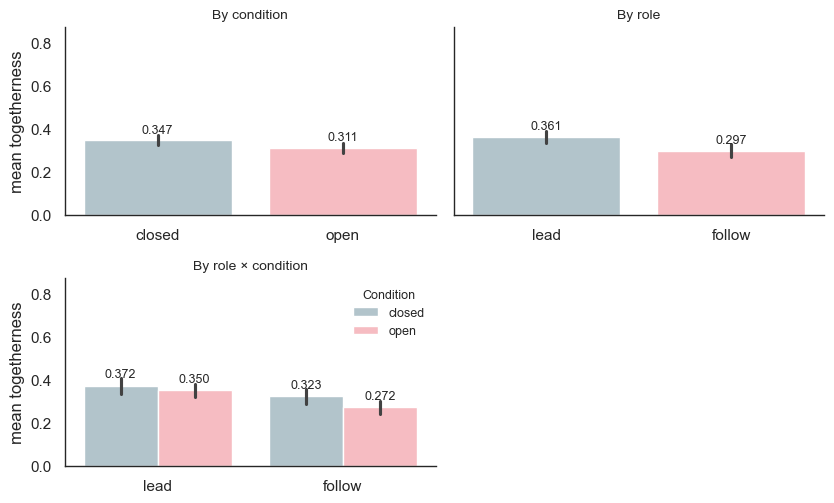

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# Helper styling + labeling
# ============================
sns.set_theme(style="white")  
palette_condition = {"closed": "#AEC6CF", "open": "#FFB3BA"}
palette_role = {"lead": "#AEC6CF", "follow": "#FFB3BA"}

def style_axes(ax, ylabel="mean togetherness"):
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.set_title("")  
    ax.grid(False)

    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)

def set_ylim_and_label(ax, data_series, label_fmt="{:.3f}", headroom=1.15, offset_frac=0.03):
    ymax = float(np.nanmax(data_series.to_numpy()))
    ax.set_ylim(0, ymax * headroom)

    y0, y1 = ax.get_ylim()
    offset = offset_frac * (y1 - y0)


    for container in ax.containers:
        for bar in container:
            h = bar.get_height()
            if h is None or np.isnan(h):
                continue
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                h + offset,
                label_fmt.format(h),
                ha="center",
                va="bottom",
                fontsize=9
            )

# ============================
# Build the three datasets
# ============================
df = Togetherness_long.copy()
metric_col = "rating_mean"
if metric_col not in df.columns:
    raise ValueError("Column rating_mean was not found in Togetherness_long.")

condition_order = ["closed", "open"]
role_order = ["lead", "follow"]

# (1) Pair-level by Condition
df_cond = (
    df.groupby(["Pair_ID", "Condition"], as_index=False)[metric_col]
      .mean()
)
df_cond["Condition"] = pd.Categorical(df_cond["Condition"], categories=condition_order, ordered=True)

# (2) Pair-level by Role
df_role = (
    df.groupby(["Pair_ID", "Role"], as_index=False)[metric_col]
      .mean()
)
df_role["Role"] = pd.Categorical(df_role["Role"], categories=role_order, ordered=True)

# (3) Pair-level by Role x Condition
df_role_cond = (
    df.groupby(["Pair_ID", "Role", "Condition"], as_index=False)[metric_col]
      .mean()
)
df_role_cond["Role"] = pd.Categorical(df_role_cond["Role"], categories=role_order, ordered=True)
df_role_cond["Condition"] = pd.Categorical(df_role_cond["Condition"], categories=condition_order, ordered=True)

# ============================
# Facet-wrap 
# ============================
fig, axes = plt.subplots(2, 2, figsize=(8.5, 5.2), sharey=True)
axes = axes.flatten() 
fig.delaxes(axes[3])

# Panel 1: Condition
ax = axes[0]
sns.barplot(
    data=df_cond,
    x="Condition", y=metric_col,
    errorbar="se",
    palette=palette_condition,
    ax=ax
)
style_axes(ax)
ax.set_title("By condition", fontsize=10)
set_ylim_and_label(ax, df_cond[metric_col])

# Panel 2: Role
ax = axes[1]
sns.barplot(
    data=df_role,
    x="Role", y=metric_col,
    errorbar="se",
    palette=palette_role,
    ax=ax
)
style_axes(ax)
ax.set_title("By role", fontsize=10)
set_ylim_and_label(ax, df_role[metric_col])

# Panel 3: Role x Condition 
sns.barplot(
    data=df_role_cond,
    x="Role", y=metric_col,
    hue="Condition",
    errorbar="se",
    palette=palette_condition,
    ax=ax
)
style_axes(ax)
ax.set_title("By role × condition", fontsize=10)
ax.legend(title="Condition", frameon=False, fontsize=9, title_fontsize=9)
set_ylim_and_label(ax, df_role_cond[metric_col])

plt.tight_layout()
plt.show()


#### T-test

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats


df = Togetherness_long.copy()

pair_id_col = "Pair_ID"
role_col = "Role"
condition_col = "Condition"
metric_col = "rating_mean"

condition_order = ("closed", "open")
role_order = ("lead", "follow")

# ---------- helpers ----------
def desc(x: np.ndarray):
    x = x.astype(float)
    n = len(x)
    m = float(np.mean(x)) if n else np.nan
    sd = float(np.std(x, ddof=1)) if n > 1 else np.nan
    se = sd / np.sqrt(n) if n > 1 else np.nan
    return n, m, sd, se

def mean_diff_ci(diff: np.ndarray):
    n = len(diff)
    if n < 2:
        return np.nan, np.nan, np.nan
    md = float(np.mean(diff))
    sd = float(np.std(diff, ddof=1))
    se = sd / np.sqrt(n)
    tcrit = stats.t.ppf(0.975, df=n - 1)
    return md, md - tcrit * se, md + tcrit * se

def fmt_p(p):
    if p < 0.001:
        return "< .001"
    return f"= {p:.3f}".replace("0.", ".")

# ---------- paired test core ----------
def paired_ttest_from_wide(wide: pd.DataFrame, a: str, b: str, label: str):
    """
    Paired t-test between columns b - a (e.g., open - closed).
    Expects wide to contain columns a and b.
    """
    if a not in wide.columns or b not in wide.columns:
        return None

    wide2 = wide[[a, b]].dropna()
    n = len(wide2)
    if n < 2:
        return None

    x_a = wide2[a].to_numpy(dtype=float)
    x_b = wide2[b].to_numpy(dtype=float)

    _, m_a, sd_a, se_a = desc(x_a)
    _, m_b, sd_b, se_b = desc(x_b)

    t, p = stats.ttest_rel(x_b, x_a)
    diff = x_b - x_a

    md, ci_low, ci_high = mean_diff_ci(diff)

    # Cohen's d (paired) 
    sd_diff = float(np.std(diff, ddof=1))
    d_paired = md / sd_diff if (sd_diff != 0 and np.isfinite(sd_diff)) else np.nan

    return {
        "comparison": label,
        "n_pairs": int(n),
        f"{a}_M": m_a, f"{a}_SD": sd_a, f"{a}_SE": se_a,
        f"{b}_M": m_b, f"{b}_SD": sd_b, f"{b}_SE": se_b,
        "mean_diff_(b-a)": float(md),
        "diff_ci95_low": float(ci_low),
        "diff_ci95_high": float(ci_high),
        "t": float(t),
        "df": int(n - 1),
        "p": float(p),
        "cohens_d_(paired)": float(d_paired),
    }

def apa_line_pair(res, a_label, b_label, decimals=3, report="sd"):
    """
    APA-like line for a paired comparison b - a.
    report: "sd" or "se"
    """
    if res is None:
        return "Not enough paired data."

    if report == "se":
        a_txt = f"M = {res[f'{a_label}_M']:.{decimals}f}, SE = {res[f'{a_label}_SE']:.{decimals}f}"
        b_txt = f"M = {res[f'{b_label}_M']:.{decimals}f}, SE = {res[f'{b_label}_SE']:.{decimals}f}"
    else:
        a_txt = f"M = {res[f'{a_label}_M']:.{decimals}f}, SD = {res[f'{a_label}_SD']:.{decimals}f}"
        b_txt = f"M = {res[f'{b_label}_M']:.{decimals}f}, SD = {res[f'{b_label}_SD']:.{decimals}f}"

    return (
        f"{res['comparison']}: {a_label} ({a_txt}), {b_label} ({b_txt}); "
        f"Δ({b_label}−{a_label}) = {res['mean_diff_(b-a)']:.{decimals}f}, "
        f"95% CI [{res['diff_ci95_low']:.{decimals}f}, {res['diff_ci95_high']:.{decimals}f}]; "
        f"t({res['df']}) = {res['t']:.{decimals}f}, p {fmt_p(res['p'])}, "
        f"Cohen’s d (paired) = {res['cohens_d_(paired)']:.{decimals}f} "
        f"(n = {res['n_pairs']})."
    )

# ============================
# 1) Condition effect: open vs closed (pair-level)
# ============================

df_cond = (
    df.groupby([pair_id_col, condition_col], as_index=False)[metric_col]
      .mean()
)

wide_cond = df_cond.pivot(index=pair_id_col, columns=condition_col, values=metric_col).reindex(columns=list(condition_order))
res_condition = paired_ttest_from_wide(
    wide_cond,
    a=condition_order[0],  # closed
    b=condition_order[1],  # open
    label="Togetherness (open vs closed)"
)

# ============================
# 2) Role effect: follow vs lead (within-pair, collapsed across conditions)
# ============================

df_role = (
    df.groupby([pair_id_col, role_col, condition_col], as_index=False)[metric_col]
      .mean()
)
# Then collapse across conditions to get one value per Pair_ID x Role
df_role = df_role.groupby([pair_id_col, role_col], as_index=False)[metric_col].mean()

wide_role = df_role.pivot(index=pair_id_col, columns=role_col, values=metric_col).reindex(columns=list(role_order))
res_role = paired_ttest_from_wide(
    wide_role,
    a=role_order[0],  # lead
    b=role_order[1],  # follow
    label="Togetherness (follow vs lead)"
)

# ============================
# Role effect within each condition (follow vs lead in closed; follow vs lead in open)
# ============================
res_role_within_condition = []
for cond in condition_order:
    sub = df.groupby([pair_id_col, role_col, condition_col], as_index=False)[metric_col].mean()
    sub = sub[sub[condition_col] == cond].copy()
    wide = sub.pivot(index=pair_id_col, columns=role_col, values=metric_col).reindex(columns=list(role_order))
    res = paired_ttest_from_wide(
        wide,
        a=role_order[0],  # lead
        b=role_order[1],  # follow
        label=f"Togetherness (follow vs lead) in {cond}"
    )
    res_role_within_condition.append(res)

# ============================
# Print results 
# ============================
print("\n=== TOGETHERNESS: PAIRED TESTS ===")
print(apa_line_pair(res_condition, a_label="closed", b_label="open", decimals=3, report="sd"))
print(apa_line_pair(res_role, a_label="lead", b_label="follow", decimals=3, report="sd"))

print("\n=== TOGETHERNESS: ROLE DIFFERENCE WITHIN EACH CONDITION (optional) ===")
for r in res_role_within_condition:
    cond_label = "closed" if r and "closed" in r["comparison"] else "open"
    print(apa_line_pair(r, a_label="lead", b_label="follow", decimals=3, report="sd"))

# ============================
# Tables
# ============================
all_results = [res_condition, res_role] + res_role_within_condition
results_df = pd.DataFrame([r for r in all_results if r is not None])
print("\n=== RESULTS TABLE ===")
print(results_df.to_string(index=False))





=== TOGETHERNESS: PAIRED TESTS ===
Togetherness (open vs closed): closed (M = 0.347, SD = 0.108), open (M = 0.311, SD = 0.104); Δ(open−closed) = -0.037, 95% CI [-0.074, 0.001]; t(20) = -2.018, p = .057, Cohen’s d (paired) = -0.440 (n = 21).
Togetherness (follow vs lead): lead (M = 0.361, SD = 0.133), follow (M = 0.297, SD = 0.138); Δ(follow−lead) = -0.064, 95% CI [-0.149, 0.022]; t(20) = -1.552, p = .136, Cohen’s d (paired) = -0.339 (n = 21).

=== TOGETHERNESS: ROLE DIFFERENCE WITHIN EACH CONDITION (optional) ===
Togetherness (follow vs lead) in closed: lead (M = 0.372, SD = 0.165), follow (M = 0.323, SD = 0.159); Δ(follow−lead) = -0.049, 95% CI [-0.159, 0.061]; t(20) = -0.926, p = .366, Cohen’s d (paired) = -0.202 (n = 21).
Togetherness (follow vs lead) in open: lead (M = 0.350, SD = 0.130), follow (M = 0.272, SD = 0.137); Δ(follow−lead) = -0.078, 95% CI [-0.155, -0.002]; t(20) = -2.148, p = .044, Cohen’s d (paired) = -0.469 (n = 21).

=== RESULTS TABLE ===
                          